In [1]:
import os, sys, pathlib
cwd = pathlib.Path.cwd()
if not (cwd / 'scripts').exists():
    if cwd.name == 'notebooks' and (cwd.parent / 'scripts').exists():
        os.chdir(cwd.parent)
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())
print('Working dir:', os.getcwd())

Working dir: /home/tanmay08/Desktop/PC/Project/Mega-Project-1


# Performance and accuracy

Quick check of accuracy, latency, bytes, and CPU. Then we compare federated (with masking) to centralized and say if they’re effectively the same.

In [2]:
# Imports and global config
from pathlib import Path
import csv
import math
import json
from datetime import datetime
import matplotlib.pyplot as plt

# Paths
CENTRAL_METRICS = Path("outputs/metrics/centralized_metrics.csv")
FL_METRICS = Path("server/state/metrics_log.csv")
SERVER_PERF = Path("server/state/perf_log.csv")
CLIENT_PERF = Path("server/state/client_perf.csv")
ARTIFACTS_DIR = Path("outputs/plots")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)


In [6]:
# Load metrics helpers

def read_centralized(path: Path):
    vals = {}
    with path.open("r", newline="") as f:
        r = csv.DictReader(f)
        for row in r:
            vals[row["metric"]] = float(row["value"])
    return vals


def read_fl_metrics(path: Path):
    rounds, aucs, f1s = [], [], []
    with path.open("r", newline="") as f:
        r = csv.DictReader(f)
        for row in r:
            rounds.append(int(row["round"]))
            aucs.append(float(row["AUC"]))
    return rounds, aucs, f1s


def read_server_perf(path: Path):
    rounds, duration, cpu, bytes_total = [], [], [], []
    with path.open("r", newline="") as f:
        r = csv.DictReader(f)
        for row in r:
            rounds.append(int(row["round"]))
            duration.append(float(row.get("duration_s", 0)))
            cpu.append(float(row.get("cpu_time_s", 0)))
            bytes_total.append(int(float(row.get("total_masked_bytes", 0))))
    return rounds, duration, cpu, bytes_total


def read_client_perf(path: Path):
    rows = []
    with path.open("r", newline="") as f:
        r = csv.DictReader(f)
        for row in r:
            rows.append({
                "client_id": row["client_id"],
                "round": int(row["round"]),
                "secagg": int(row.get("secagg", 0)),
                "local_train_time_s": float(row.get("local_train_time_s", 0)),
                "cpu_time_s": float(row.get("cpu_time_s", 0)),
                "upload_bytes": int(float(row.get("upload_bytes", 0))),
            })
    return rows


In [7]:
# Load data
if not CENTRAL_METRICS.exists():
    raise FileNotFoundError(f"Missing centralized metrics: {CENTRAL_METRICS}")
if not FL_METRICS.exists():
    raise FileNotFoundError(f"Missing federated metrics log: {FL_METRICS}")
if not SERVER_PERF.exists():
    raise FileNotFoundError(f"Missing server perf log: {SERVER_PERF}")
if not CLIENT_PERF.exists():
    raise FileNotFoundError(f"Missing client perf log: {CLIENT_PERF}")

cen = read_centralized(CENTRAL_METRICS)
fl_rounds, fl_aucs, fl_f1s = read_fl_metrics(FL_METRICS)
sv_rounds, sv_dur, sv_cpu, sv_bytes = read_server_perf(SERVER_PERF)
cl_rows = read_client_perf(CLIENT_PERF)

cen_auc = cen.get("AUC", 0.0)
cen_f1 = cen.get("F1", 0.0)
fl_auc_last = fl_aucs[-1] if fl_aucs else 0.0
fl_f1_last = fl_f1s[-1] if fl_f1s else 0.0
print({"centralized_auc": cen_auc, "federated_auc_last": fl_auc_last, "centralized_f1": cen_f1, "federated_f1_last": fl_f1_last})


{'centralized_auc': 0.980566, 'federated_auc_last': 0.980398, 'centralized_f1': 0.0, 'federated_f1_last': 0.0}


Saved outputs/plots/centralized_vs_fl_notebook.png


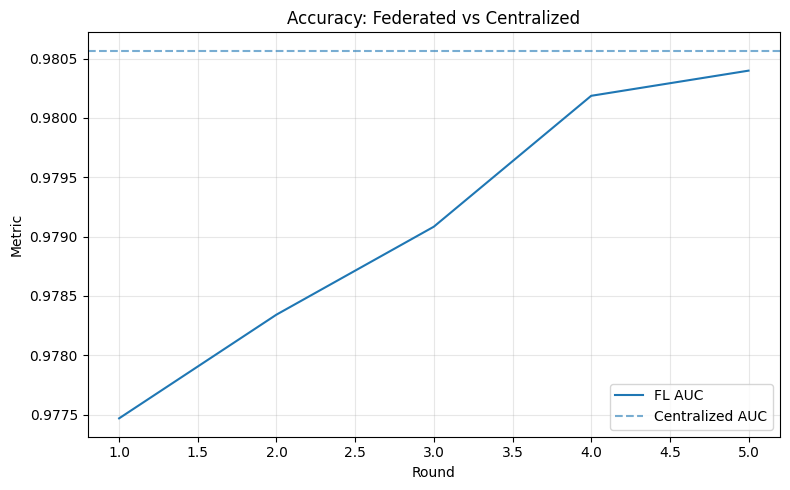

In [10]:
# Plot accuracy curves and overlay centralized lines
plt.figure(figsize=(8,5))
if fl_rounds:
    plt.plot(fl_rounds, fl_aucs, label='FL AUC')
plt.axhline(cen_auc, color='C0', linestyle='--', alpha=0.6, label='Centralized AUC')
plt.xlabel('Round')
plt.ylabel('Metric')
plt.title('Accuracy: Federated vs Centralized')
plt.grid(True, alpha=0.3)
plt.legend()
acc_plot_path = ARTIFACTS_DIR / 'centralized_vs_fl_notebook.png'
plt.tight_layout(); plt.savefig(acc_plot_path, dpi=150)
print(f'Saved {acc_plot_path}')


Saved outputs/plots/latency_per_round.png
Saved outputs/plots/bytes_per_client_per_round.png
{'avg_round_latency_s': 1.3399, 'avg_server_cpu_time_s': 0.7061, 'avg_upload_bytes_per_client': 248}


/tmp/ipykernel_37185/2481026701.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, labels=[str(x) for x in labels], showfliers=False)


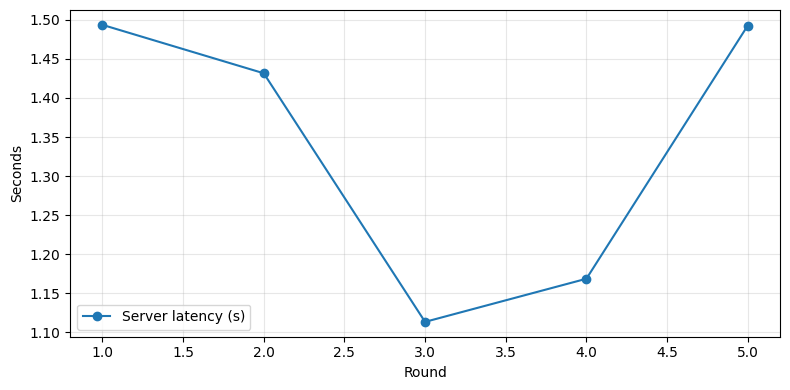

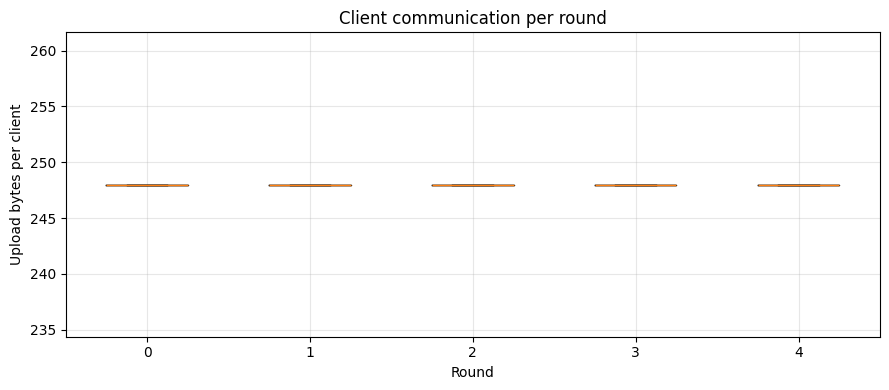

In [11]:
# Latency per round and client upload bytes
import statistics as stats

# Latency line plot
plt.figure(figsize=(8,4))
plt.plot(sv_rounds, sv_dur, marker='o', label='Server latency (s)')
plt.xlabel('Round'); plt.ylabel('Seconds'); plt.grid(True, alpha=0.3); plt.legend()
lat_plot_path = ARTIFACTS_DIR / 'latency_per_round.png'
plt.tight_layout(); plt.savefig(lat_plot_path, dpi=150)
print(f'Saved {lat_plot_path}')

# Bytes per client per round (boxplot)
round_bytes = {}
for row in cl_rows:
    round_bytes.setdefault(row['round'], []).append(row['upload_bytes'])
labels = sorted(round_bytes.keys())
vals = [round_bytes[r] for r in labels]
plt.figure(figsize=(9,4))
plt.boxplot(vals, labels=[str(x) for x in labels], showfliers=False)
plt.xlabel('Round'); plt.ylabel('Upload bytes per client'); plt.title('Client communication per round'); plt.grid(True, alpha=0.3)
bytes_plot_path = ARTIFACTS_DIR / 'bytes_per_client_per_round.png'
plt.tight_layout(); plt.savefig(bytes_plot_path, dpi=150)
print(f'Saved {bytes_plot_path}')

# Summary stats
avg_latency = stats.mean(sv_dur) if sv_dur else 0
avg_server_cpu = stats.mean(sv_cpu) if sv_cpu else 0
all_client_bytes = [b for arr in vals for b in arr]
avg_bytes_per_client = stats.mean(all_client_bytes) if all_client_bytes else 0
print({'avg_round_latency_s': round(avg_latency,4), 'avg_server_cpu_time_s': round(avg_server_cpu,4), 'avg_upload_bytes_per_client': int(avg_bytes_per_client)})


In [7]:
# Accuracy equivalence decision
EPS = 0.01  # absolute tolerance
auc_diff = abs(cen_auc - fl_auc_last)
f1_diff = abs(cen_f1 - fl_f1_last)
print({'auc_diff': auc_diff, 'f1_diff': f1_diff, 'epsilon': EPS})
if auc_diff <= EPS and f1_diff <= EPS:
    print("Conclusion: Federated (with Bonawitz) and centralized are equivalent within ±0.01 for AUC and F1.")
else:
    print("Conclusion: Differences exceed the ±0.01 tolerance; consider more rounds or tuning.")


{'auc_diff': 0.00017900000000004024, 'f1_diff': 0.0, 'epsilon': 0.01}
Conclusion: Federated (with Bonawitz) and centralized are equivalent within ±0.01 for AUC and F1.
